<a href="https://colab.research.google.com/github/yseeker/pytorch-gan/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms as transforms

from PIL import Image

class CFG:
    n_epoch = 2000
    batch_size = 64
    lr = 2e-4
    nch_g = 128
    nch_d = 128
    z_dim = 100
    beta1 = 0.5

In [2]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5, ))
])
dataset = dset.MNIST('./drive/MyDrive/data/', download = True, train = True, transform = transform)
dataloader = DataLoader(dataset = dataset, batch_size=CFG.batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./drive/MyDrive/data/MNIST/raw/train-images-idx3-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./drive/MyDrive/data/MNIST/raw/train-labels-idx1-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./drive/MyDrive/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./drive/MyDrive/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./drive/MyDrive/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + '/g_{:04d}.pth'.format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + '/g_{:04d}.pth'.format(epoch)
    )

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim = 100, ngf = 128, nc = 1):
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4*ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4*ngf, 2*ngf, 3, 2, 0)
        self.convt3 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size,stride,padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out

class Discrimnator(nn.Module):
    def __init__(self, nc = 1, ndf = 128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm = False)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(4*ndf, 1, 3, 1, 0),
            nn.Sigmoid()
        )
    
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1,
                     has_batch_norm = True):
        layers = [
                  nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(z_dim = CFG.z_dim, ngf = CFG.nch_g).to(device)
generator.apply(weights_init)

discriminator = Discrimnator(nc = 1, ndf = CFG.nch_d).to(device)
discriminator.apply(weights_init)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr = CFG.lr, betas=(CFG.beta1, 0.999), weight_decay = 1e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr = CFG.lr, betas=(CFG.beta1, 0.999), weight_decay = 1e-5)

model_name = 'DCGGAN'
f_path_result = './drive/MyDrive/result/{}'.format(model_name)
f_path_params = './drive/MyDrive/result/{}'.format(model_name)

os.makedirs(f_path_result, exist_ok = True)
os.makedirs(f_path_params, exist_ok = True)

In [6]:
def train_one_step(real_imgs, noise, labels_valid, labels_fake):
    """Train Discriminator"""
    optimizer_D.zero_grad()
    gen_imgs = generator(noise)
    out_real = discriminator(real_imgs)
    out_fake = discriminator(gen_imgs.detach())
    real_loss = criterion(out_real, labels_valid)
    fake_loss = criterion(out_fake, labels_fake)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    """Train Generator"""
    optimizer_G.zero_grad()
    # Loss measures generator's ability to fool the discriminator
    g_loss = criterion(discriminator(gen_imgs), labels_valid)
    g_loss.backward()
    optimizer_G.step()

    return gen_imgs, g_loss, d_loss

100%|██████████| 938/938 [00:38<00:00, 24.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: 0.46155111756978007, lossG: 3.445170250671632


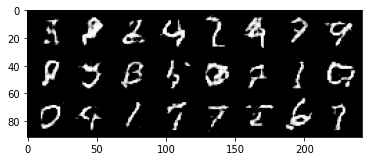

100%|██████████| 938/938 [00:38<00:00, 24.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: 0.5743108501693587, lossG: 2.417280765488617


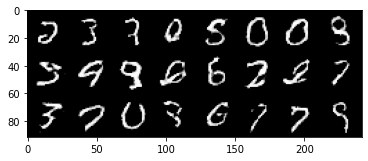

100%|██████████| 938/938 [00:38<00:00, 24.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, lossD: 0.5984453956074298, lossG: 2.400882769193349


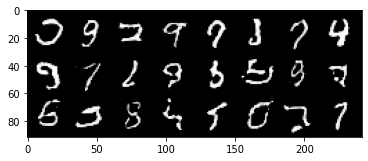

100%|██████████| 938/938 [00:38<00:00, 24.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, lossD: 0.6177767994783835, lossG: 2.4214830076389475


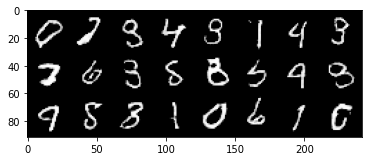

100%|██████████| 938/938 [00:38<00:00, 24.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, lossD: 0.6277247782804565, lossG: 2.429075795259557


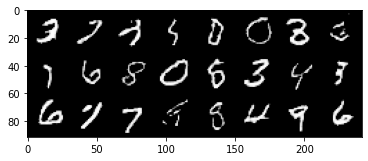

100%|██████████| 938/938 [00:38<00:00, 24.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, lossD: 0.5732862596858793, lossG: 2.5980033707707677


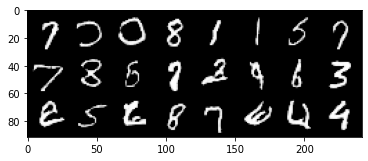

100%|██████████| 938/938 [00:38<00:00, 24.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, lossD: 0.5780538274471694, lossG: 2.608342187681686


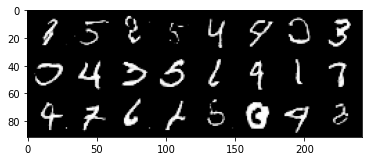

100%|██████████| 938/938 [00:38<00:00, 24.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, lossD: 0.5634959036353301, lossG: 2.7035032546183446


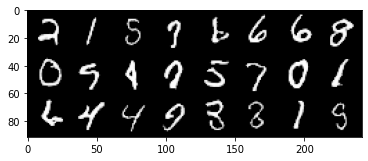

100%|██████████| 938/938 [00:38<00:00, 24.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, lossD: 0.5401449830833275, lossG: 2.7865351561004164


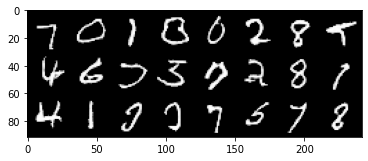

100%|██████████| 938/938 [00:38<00:00, 24.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, lossD: 0.5331742428322591, lossG: 2.8586320335041484


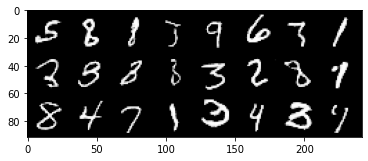

100%|██████████| 938/938 [00:38<00:00, 24.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10, lossD: 0.49978723415116005, lossG: 2.9183798287707226


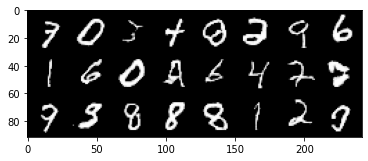

100%|██████████| 938/938 [00:38<00:00, 24.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11, lossD: 0.500336412713726, lossG: 2.952094397088612


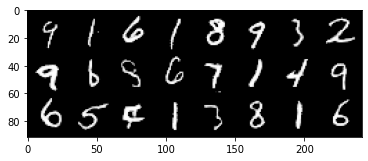

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12, lossD: 0.48828567929867744, lossG: 3.0166885067087246


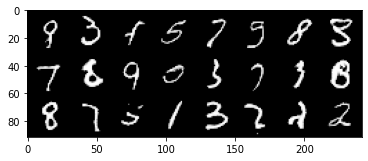

100%|██████████| 938/938 [00:38<00:00, 24.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13, lossD: 0.4624640867114067, lossG: 3.1152890570350547


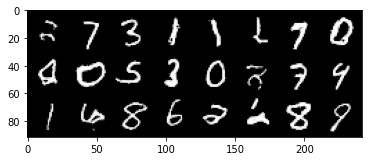

100%|██████████| 938/938 [00:38<00:00, 24.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14, lossD: 0.46551285927166053, lossG: 3.127206408519989


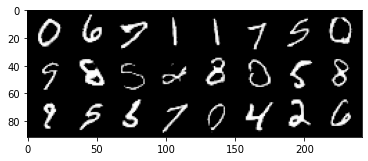

100%|██████████| 938/938 [00:38<00:00, 24.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15, lossD: 0.44058992375315886, lossG: 3.208589670405205


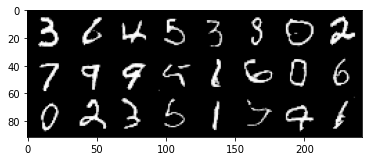

100%|██████████| 938/938 [00:38<00:00, 24.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16, lossD: 0.43071529780750845, lossG: 3.317285388612798


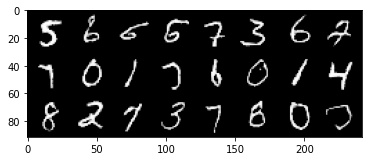

100%|██████████| 938/938 [00:38<00:00, 24.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17, lossD: 0.46259096984479475, lossG: 3.2350902082696398


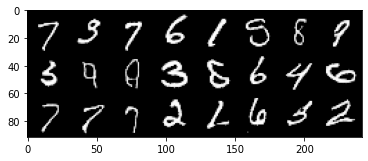

100%|██████████| 938/938 [00:38<00:00, 24.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18, lossD: 0.43272357074214196, lossG: 3.3070853555888764


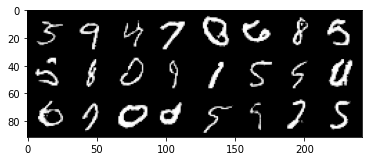

100%|██████████| 938/938 [00:38<00:00, 24.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19, lossD: 0.4289276632291676, lossG: 3.361127522303415


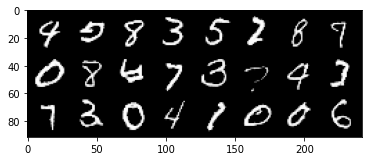

100%|██████████| 938/938 [00:38<00:00, 24.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, lossD: 0.3971761273089121, lossG: 3.4036028513522036


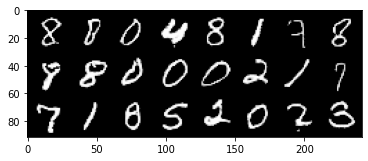

100%|██████████| 938/938 [00:38<00:00, 24.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21, lossD: 0.4091886805652428, lossG: 3.487942227263695


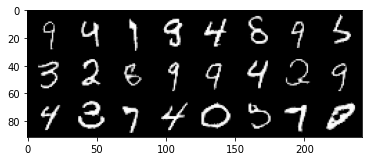

100%|██████████| 938/938 [00:39<00:00, 24.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22, lossD: 0.4092940002965775, lossG: 3.464128118111635


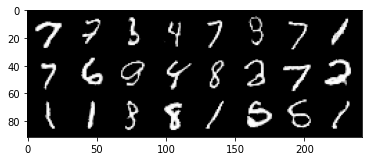

100%|██████████| 938/938 [00:38<00:00, 24.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23, lossD: 0.3982163959863915, lossG: 3.5279981968944263


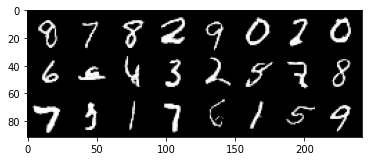

100%|██████████| 938/938 [00:38<00:00, 24.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 24, lossD: 0.3937611033969215, lossG: 3.5403822368578806


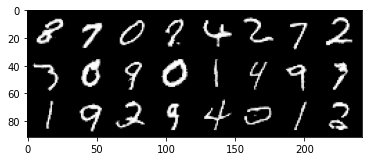

100%|██████████| 938/938 [00:38<00:00, 24.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25, lossD: 0.37604494819413625, lossG: 3.6716609292987314


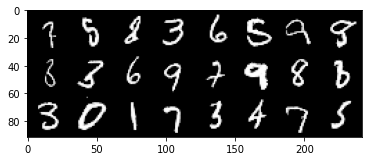

100%|██████████| 938/938 [00:38<00:00, 24.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 26, lossD: 0.3925982598922273, lossG: 3.6001861010596694


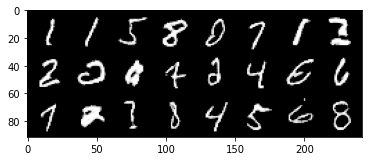

100%|██████████| 938/938 [00:38<00:00, 24.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 27, lossD: 0.35093215034047426, lossG: 3.726449752000095


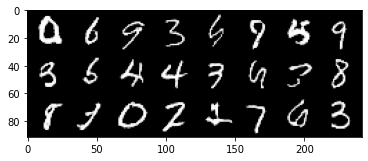

100%|██████████| 938/938 [00:39<00:00, 24.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 28, lossD: 0.38406187840806905, lossG: 3.686153136495588


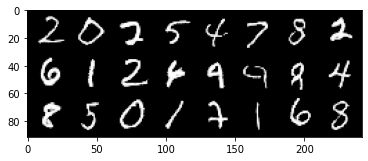

100%|██████████| 938/938 [00:38<00:00, 24.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 29, lossD: 0.4163767161375996, lossG: 3.6585367487421805


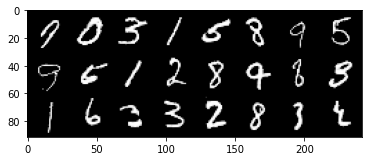

100%|██████████| 938/938 [00:38<00:00, 24.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30, lossD: 0.33599798455596097, lossG: 3.7756632495441163


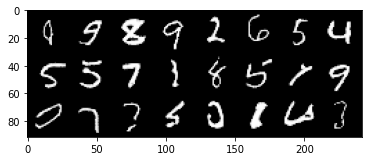

100%|██████████| 938/938 [00:38<00:00, 24.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31, lossD: 0.3652967570552122, lossG: 3.808877876763151


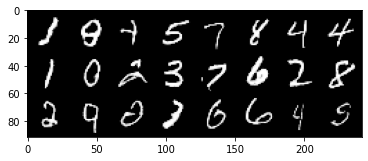

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 32, lossD: 0.3872585895854527, lossG: 3.7017568972891075


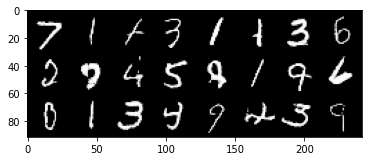

100%|██████████| 938/938 [00:38<00:00, 24.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 33, lossD: 0.3588992891900702, lossG: 3.799519915348177


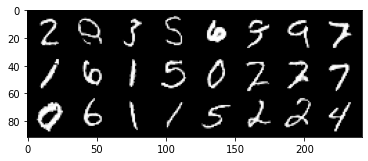

100%|██████████| 938/938 [00:38<00:00, 24.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 34, lossD: 0.3132402740125018, lossG: 3.8785569700541527


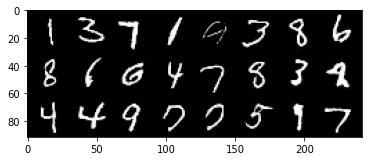

100%|██████████| 938/938 [00:38<00:00, 24.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 35, lossD: 0.38007189605488323, lossG: 3.8595997047529162


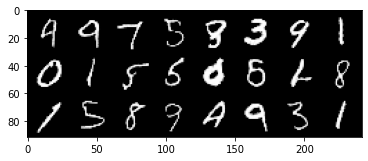

100%|██████████| 938/938 [00:38<00:00, 24.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 36, lossD: 0.3392218735291442, lossG: 3.9523617928502146


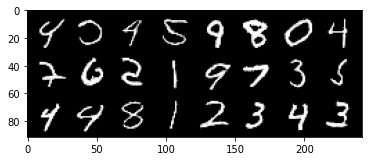

100%|██████████| 938/938 [00:38<00:00, 24.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 37, lossD: 0.3149320061590626, lossG: 3.94342811612178


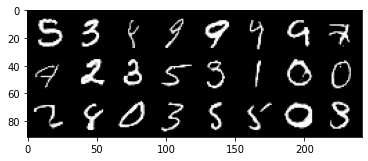

100%|██████████| 938/938 [00:38<00:00, 24.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 38, lossD: 0.34219592501089646, lossG: 3.9980305238430307


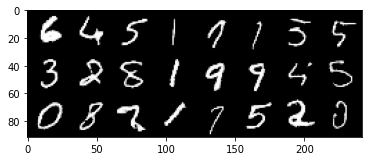

100%|██████████| 938/938 [00:38<00:00, 24.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 39, lossD: 0.35742525529585034, lossG: 3.9165591506688577


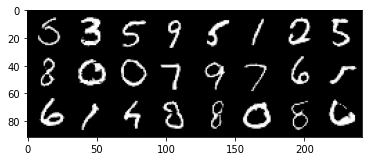

100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40, lossD: 0.3053015418914653, lossG: 4.042191271271024


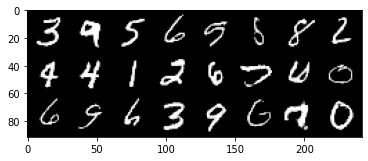

100%|██████████| 938/938 [00:38<00:00, 24.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 41, lossD: 0.3483789396851556, lossG: 3.9977450986397263


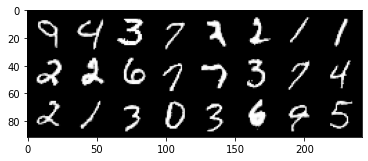

100%|██████████| 938/938 [00:38<00:00, 24.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 42, lossD: 0.3695981078334391, lossG: 3.9892147516668923


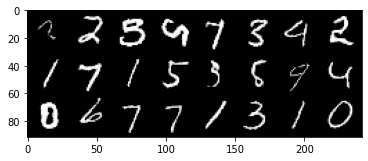

100%|██████████| 938/938 [00:38<00:00, 24.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 43, lossD: 0.28470145562675586, lossG: 4.042677054590762


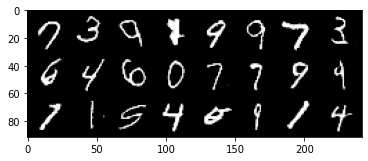

100%|██████████| 938/938 [00:38<00:00, 24.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 44, lossD: 0.34082561834598146, lossG: 4.087120055453355


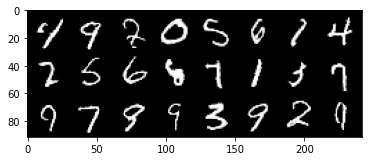

100%|██████████| 938/938 [00:38<00:00, 24.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 45, lossD: 0.371946437939652, lossG: 4.022204420781498


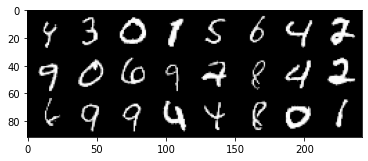

100%|██████████| 938/938 [00:38<00:00, 24.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 46, lossD: 0.28889836073080616, lossG: 4.163271152452111


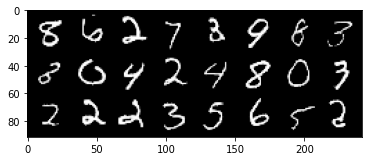

100%|██████████| 938/938 [00:38<00:00, 24.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 47, lossD: 0.2904216668415648, lossG: 4.225192792205287


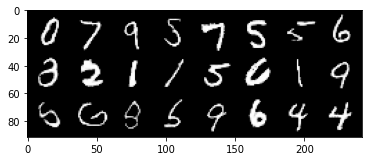

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 48, lossD: 0.2830861938962423, lossG: 4.253310383065169


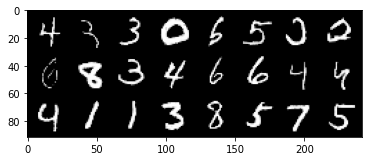

100%|██████████| 938/938 [00:38<00:00, 24.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 49, lossD: 0.34807083465015964, lossG: 4.148058732773469


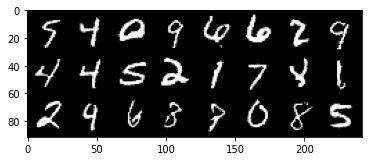

100%|██████████| 938/938 [00:38<00:00, 24.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 50, lossD: 0.2921555419382987, lossG: 4.253040833037291


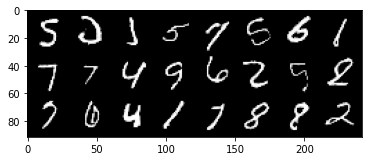

100%|██████████| 938/938 [00:38<00:00, 24.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 51, lossD: 0.3034285754878829, lossG: 4.269601514789342


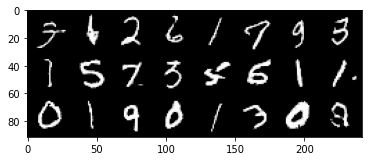

100%|██████████| 938/938 [00:38<00:00, 24.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 52, lossD: 0.31379655794278266, lossG: 4.255828934382083


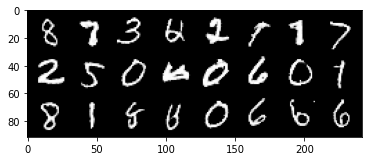

100%|██████████| 938/938 [00:38<00:00, 24.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 53, lossD: 0.2967225903553813, lossG: 4.303920117431263


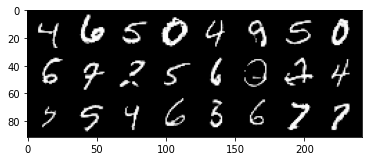

100%|██████████| 938/938 [00:38<00:00, 24.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 54, lossD: 0.34446065727946984, lossG: 4.269863563325195


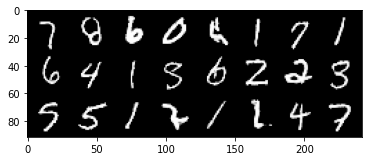

100%|██████████| 938/938 [00:38<00:00, 24.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 55, lossD: 0.2830250076274437, lossG: 4.290474088727507


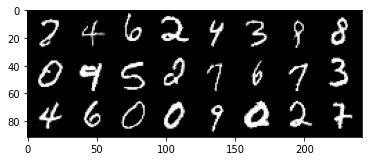

100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 56, lossD: 0.2913840273176747, lossG: 4.420972777200914


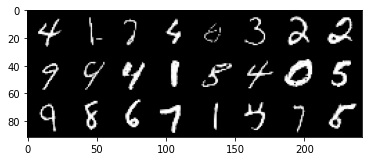

100%|██████████| 938/938 [00:38<00:00, 24.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 57, lossD: 0.2916706795536125, lossG: 4.3293307608188085


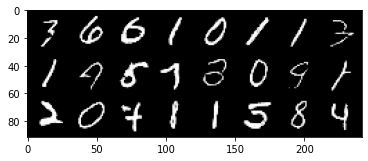

100%|██████████| 938/938 [00:38<00:00, 24.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 58, lossD: 0.29405853039086627, lossG: 4.346807459778369


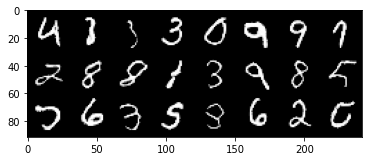

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 59, lossD: 0.27098731687868327, lossG: 4.434242108260899


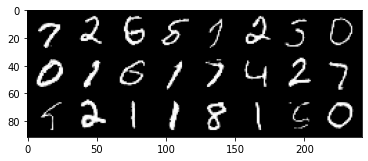

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 60, lossD: 0.2579405419012186, lossG: 4.488749046823871


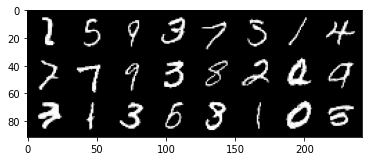

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 61, lossD: 0.30291762279628565, lossG: 4.479085241092929


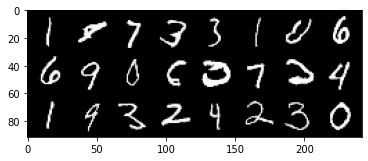

100%|██████████| 938/938 [00:38<00:00, 24.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 62, lossD: 0.2608338161838302, lossG: 4.5280332623133015


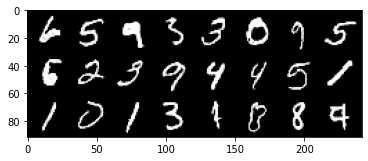

100%|██████████| 938/938 [00:38<00:00, 24.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 63, lossD: 0.2743069516784791, lossG: 4.505739606174229


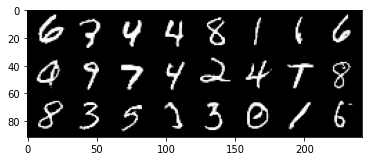

100%|██████████| 938/938 [00:38<00:00, 24.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 64, lossD: 0.28347011412015316, lossG: 4.601891266384613


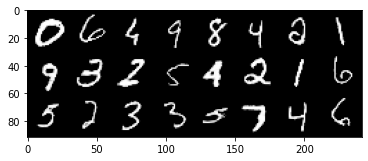

100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 65, lossD: 0.23059348217142162, lossG: 4.591177781571203


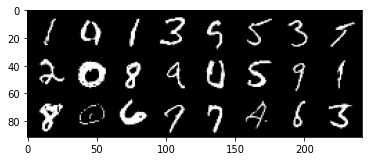

100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 66, lossD: 0.3348586195742271, lossG: 4.458997448044482


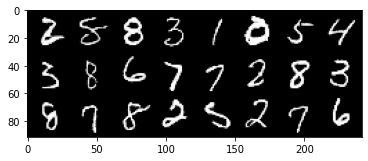

100%|██████████| 938/938 [00:38<00:00, 24.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 67, lossD: 0.2804124447832833, lossG: 4.47993320897857


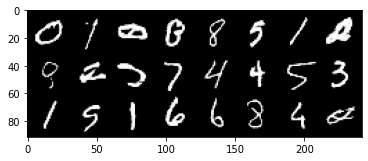

100%|██████████| 938/938 [00:38<00:00, 24.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 68, lossD: 0.2990030807409205, lossG: 4.587361764885596


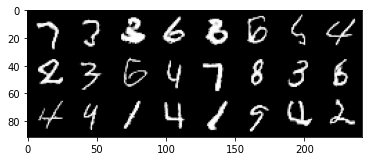

100%|██████████| 938/938 [00:38<00:00, 24.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 69, lossD: 0.23455156292170604, lossG: 4.603485668963715


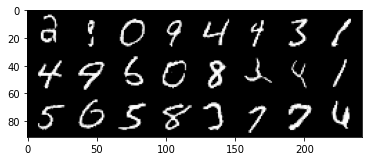

100%|██████████| 938/938 [00:38<00:00, 24.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 70, lossD: 0.2518280883893561, lossG: 4.602530000306396


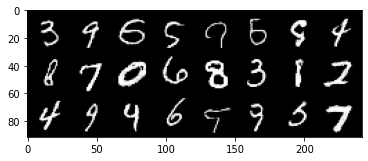

100%|██████████| 938/938 [00:38<00:00, 24.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 71, lossD: 0.2685834778222575, lossG: 4.630477741305063


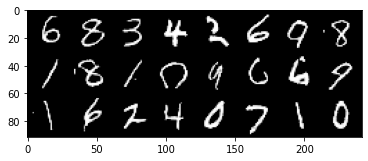

100%|██████████| 938/938 [00:38<00:00, 24.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 72, lossD: 0.2336864853992677, lossG: 4.692683771602126


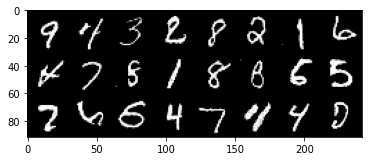

100%|██████████| 938/938 [00:38<00:00, 24.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 73, lossD: 0.2527698581553757, lossG: 4.7305071146916475


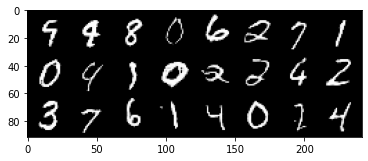

100%|██████████| 938/938 [00:38<00:00, 24.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 74, lossD: 0.2891335384840809, lossG: 4.603154656221109


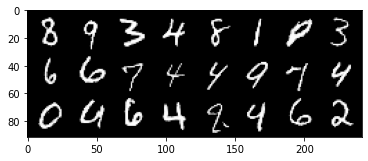

 39%|███▊      | 363/938 [00:15<00:23, 24.34it/s]

KeyboardInterrupt: ignored

In [7]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
for epoch in range(CFG.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position = 0)):
        batch_size = real_imgs.size()[0]
        shape = (batch_size, 1, 1, 1)
        real_imgs = real_imgs.to(device)
        noise = torch.randn(batch_size, CFG.z_dim, 1, 1).to(device)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)

        fake_imgs, lossG, lossD = train_one_step(real_imgs, noise, labels_real, labels_fake)

        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print('epoch: {}, lossD: {}, lossG: {}'.format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

    # save imgs and parameters
    vutils.save_image(fake_imgs, f_path_result + '/{}.jpg'.format(epoch))
    save_params(f_path_params, epoch, discriminator, generator)